In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from templates import *

In [8]:
device = 'cuda:0'
conf = ffhq256_autoenc()
# print(conf.name)
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

Global seed set to 0


Model params: 160.69 M


In [197]:
# %%timeit
# Image-Read
data = ImageDataset('imgs_test_align', image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
# batch = data[0]['img'][None]
batch = torch.stack([*[d['img'] for d in data]])

# Encode
cond = model.encode(batch.to(device))
xT = model.encode_stochastic(batch.to(device), cond, T=250)

# Decode
pred = model.render(xT, cond, T=20)

CPU times: total: 0 ns
Wall time: 0 ns
7.98 s ± 18.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


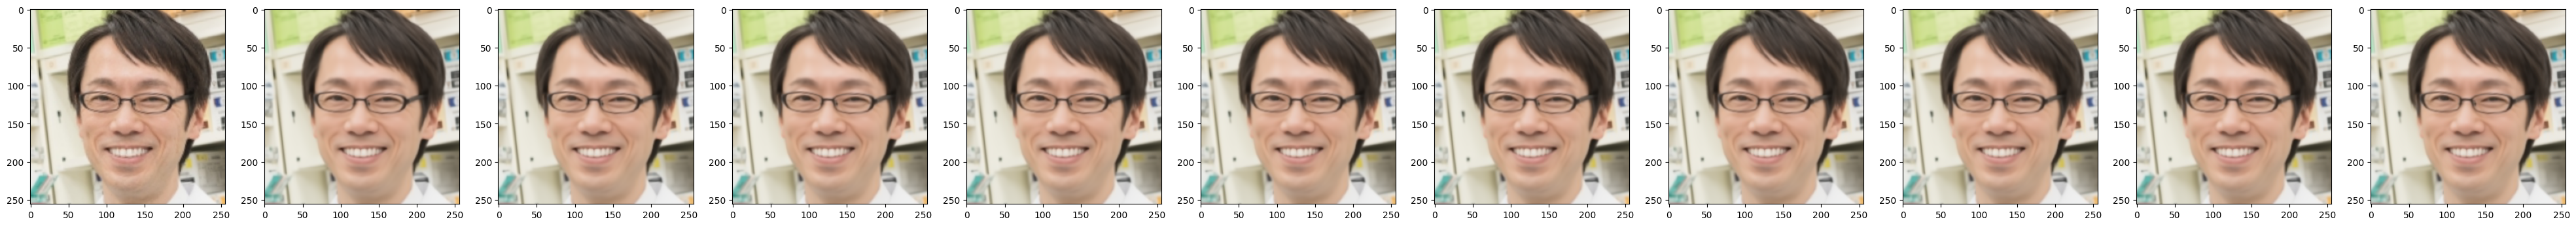

In [116]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 11, figsize=(50, 25))

ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
for i in range(1, 11):
    ax[i].imshow(pred[i-1].permute(1, 2, 0).cpu())

In [170]:
from torchvision.utils import *
output_path = 'imgs_recon'
if not osp.exists(output_path): os.makedirs(output_path)

for i, p in enumerate(pred):
    save_image(p, '%s/test%02d.png' % (output_path, i+1))

In [121]:
from ssim import *

In [153]:
ori = ori.to(device)
ssim(ori[0][None], pred[0][None])

tensor(0.9804, device='cuda:0')

In [179]:
# import cv2
ori_path = 'imgs_test_align/test01.png'
recon_path = 'imgs_recon/test01.png'
ori = torch.from_numpy(cv2.imread(ori_path).astype(np.float32)).to(device)
recon = torch.from_numpy(cv2.imread(recon_path).astype(np.float32)).to(device)
ori = ori.permute(2, 0, 1)[None]
recon = recon.permute(2, 0, 1)[None]
ssim(ori, recon)

tensor(0.9118, device='cuda:0')